In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os, sys


# Set seed
torch.manual_seed(0)
from torch.optim.lr_scheduler import StepLR

sys.path.append("..")

from src.utils import uniform_weights
from src.ground_cost import l2_cost2, l2_cost, batch_l2_cost2
from src.discrete_entropic_reg import (soft_c_transform, 
                                       soft_exponential_cost, 
                                       normalised_soft_exponential_cost, 
                                       stochastic_dual_approx)

In [2]:
from src.trainer import Trainer
from src.quantizer import Quantizer
from src.schedulers import scheduler_constructor

In [3]:
def scheduler_constructor(gamma):
    return lambda optimizer: StepLR(optimizer, step_size=1, gamma=gamma)

In [12]:
num_atoms = 100
dim = 2
init_g = np.random.random(size = (num_atoms))
init_ys = np.random.random(size = (num_atoms, dim))
epsilon = 0.01

In [13]:
quantizer_obj = Quantizer(init_g, init_ys, epsilon, ground_cost=batch_l2_cost2)

In [14]:
alpha_dist = dist.Uniform(torch.tensor(np.repeat(0., dim)), torch.tensor(np.repeat(1., dim)))


In [15]:
# optimizers
learning_rate = 0.1
optimizer_atoms = torch.optim.ASGD([quantizer_obj.ys], lr=learning_rate)
optimizer_map = torch.optim.ASGD([quantizer_obj.g], lr=learning_rate)

In [16]:
trainer = Trainer(alpha_dist, 
                  quantizer_obj, 
                  optimizer_map, 
                  optimizer_atoms, 
                  map_scheduler_func = scheduler_constructor(0.8), 
                  atoms_scheduler_func=scheduler_constructor(0.8))

In [17]:
trainer.train(n_iters=10000, batch_size=1, n_sub_iters_atoms=10, n_sub_iters_map=10, lr_steps=100)

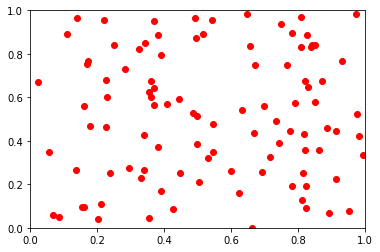

In [18]:

y_plot = init_ys
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

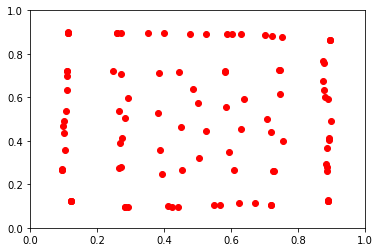

In [19]:
ys = trainer.quantizer.ys
y_plot = ys.detach().numpy()
plt.plot(y_plot[:,0], y_plot[:,1], "ro")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()